# Increase Dimensionailities (concatenate in 1st dimension)

## Package Installation

In [1]:
import os
import sys

# Path

In [2]:
print(os.getcwd())

C:\Users\Administrator-1\Downloads\H2\HI


In [3]:
training_data_kok14_galfa = os.path.join(os.getcwd(),"data", "other", "training_data_kok14_galfa.pickle")

## Libraries

In [4]:

from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
import os
import argparse

import glob
import pickle

## Data preparation

In [5]:
data = pickle.load(open(training_data_kok14_galfa, 'rb'))
# training data
X_train = data['X_train']
Y_train = data['Y_train']
# Observed test data
X_test = data['X_test']
Y_test = data['Y_test']

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Administrator-1\\Downloads\\H2\\HI\\data\\other\\training_data_kok14_galfa.pickle'

## Split train, validation and testing set from X_train and Y_train.

In [ ]:
# set aside 20% of train and test data for evaluation
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, 
                                                    test_size=0.2, shuffle = True, 
                                                    random_state = 8)
# Use the same function above for the validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

In [ ]:
print("x_train=",x_train.shape, ", y_train=", y_train.shape)
print("x_val=",x_val.shape, ", y_val=", y_val.shape)
print("x_test=",x_test.shape, ", y_test=", y_test.shape)

In [ ]:
x_train[0]

## Plot a few training samples

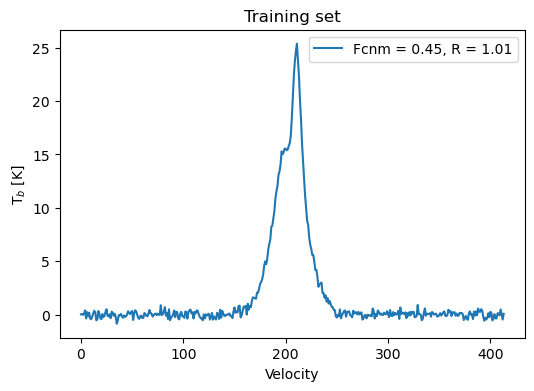

In [8]:
# Spectrum in training set
plt.figure(figsize=(6,4))
plt.plot(X_train[0, :], label=f'Fcnm = {round(Y_train[20000,0], 2)}, R = {round(Y_train[0,1], 2)}')

plt.title('Training set')
plt.xlabel('Velocity')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

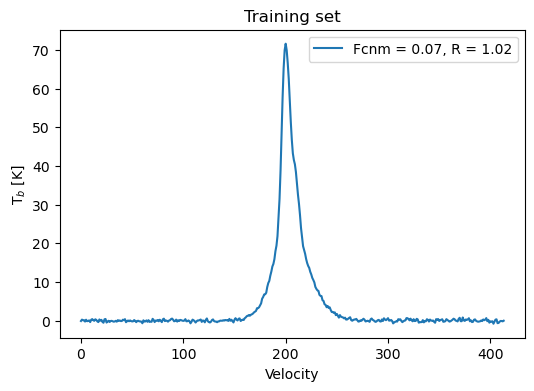

In [9]:
# Spectrum in training set
plt.figure(figsize=(6,4))
plt.plot(X_train[1000, :], label=f'Fcnm = {round(Y_train[10000,0], 2)}, R = {round(Y_train[10000,1], 2)}')

plt.title('Training set')
plt.xlabel('Velocity')
plt.ylabel('T$_b$ [K]')
plt.legend()
plt.show()

## Data loader

In [10]:
# data loader 
class HI_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform=None, target_transform=None):
        
        self.x = x
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.y[:,0])
    
    def __getitem__(self, idx):
        
        zero = np.linspace(0, 1.0, 414).reshape(1, -1)
        spectra = self.x[idx,:]
        two = zero + spectra**2
        result = np.vstack((zero,spectra, two))
        #print(result)
        label = self.y[idx,:]
        if self.transform:
            result = self.transform(result)
            #print(result.shape)
            result = result.reshape(1, result.shape[0], result.shape[1])
        if self.target_transform:
            label = self.target_transform(label)
        return result, label

In [11]:
# transform to tenor 
class ToTensor_x():
    def __call__(self, sample):
        x = torch.from_numpy(sample)
        return x

In [12]:
# transform to tenor 
class ToTensor_y():
    def __call__(self, sample):
        x = torch.from_numpy(sample)
        return x

In [13]:
# initialize dataset
dataset_train = HI_dataset(x_train, y_train,transform=ToTensor_x(), target_transform=ToTensor_y())
dataset_val = HI_dataset(x_val, y_val,transform=ToTensor_x(), target_transform=ToTensor_y())
dataset_test = HI_dataset(x_test, y_test,transform=ToTensor_x(), target_transform=ToTensor_y())

In [14]:
# initialize data loader
batch_size = 20 
train_loader = torch.utils.data.DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle =True)
valid_loader = torch.utils.data.DataLoader(dataset = dataset_val, batch_size = batch_size, shuffle =False)
test_loader = torch.utils.data.DataLoader(dataset = dataset_test, batch_size = batch_size, shuffle =False)

In [15]:
# test data loader
val = iter(test_loader)
A,B = next(val)
print(A.shape)
print(B.shape)

torch.Size([20, 1, 3, 414])
torch.Size([20, 2])


## CNN Model

In [20]:
import math
class Net_origin_deep(nn.Module):
    def __init__(self, num_output=2, in_channels=1, num_output_1=72, num_output_2=64, num_output_3=56, num_output_4=48):
        super(Net_origin_deep, self).__init__()
        # layers
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels=num_output_1, 
                               kernel_size=(2,6), stride=1, padding=0, bias=True, 
                               padding_mode='zeros')
        
        self.bn1 = nn.BatchNorm2d(num_output_1)
        
        self.conv2 = nn.Conv2d(in_channels= num_output_1, out_channels=num_output_2,
                               kernel_size=(1,40), stride=1, padding=0, bias=True,
                               padding_mode='zeros')
        
        self.bn2 = nn.BatchNorm2d(num_output_2)
        
            
        self.conv3 = nn.Conv2d(in_channels = num_output_2, out_channels=num_output_3,
                               kernel_size=(1,6), stride=1, padding=0, bias=True,
                               padding_mode='zeros')
        
        self.bn3 = nn.BatchNorm2d(num_output_3)
        
        self.conv4 = nn.Conv2d(in_channels= num_output_3, out_channels=num_output_4,
                               kernel_size=(1,40), stride=1, padding=0, bias=True, 
                               padding_mode='zeros')
        
        self.bn4 = nn.BatchNorm2d(num_output_4)
        
        self.conv5 = nn.Conv2d(in_channels = num_output_4, out_channels=40, 
                               kernel_size=(1,6), stride=1, padding=0, bias=True,
                               padding_mode='zeros')
        
        self.bn5 = nn.BatchNorm2d(40)
        
        self.conv6 = nn.Conv2d(in_channels= 40, out_channels=32, kernel_size=(1,40),
                               stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn6 = nn.BatchNorm2d(32)
        
        self.conv7 = nn.Conv2d(in_channels = 32, out_channels=16, kernel_size=(1,6), 
                               stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.Conv2d(in_channels= 16, out_channels=8, kernel_size=(1,40),
                               stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn8 = nn.BatchNorm2d(8)
        
        self.dropout = nn.Dropout(0.30)

        self.linear = nn.Linear(3808, num_output)
        self.flatten = nn.Flatten()

        # init parameter
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0]*m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        #print(1, x.size())
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        #print(2, x.size())
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        #print(3, x.size())
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        #
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        #
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        #
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        #
        x = self.conv7(x)
        x = self.bn7(x)
        x = F.relu(x)
        #
        x = self.conv8(x)
        x = self.bn8(x)
        x = F.relu(x)
        #
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        #print(4, x.size())
        return x

## Loss and Optimization

In [21]:
# training setting
lr = 0.005
#lr = 0.0005
num_epoch = 80
num_step = x_train.shape[0]/batch_size
loss_function = nn.MSELoss()
model =  Net_origin_deep()
best_err = 100000
optimizer = torch.optim.SGD(model.parameters(), lr)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones = [65], 
                                                 gamma=0.1, last_epoch=-1, verbose=False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu' )
model.to(device)

Net_origin_deep(
  (conv1): Conv2d(1, 72, kernel_size=(2, 6), stride=(1, 1))
  (bn1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(72, 64, kernel_size=(1, 40), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 56, kernel_size=(1, 6), stride=(1, 1))
  (bn3): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(56, 48, kernel_size=(1, 40), stride=(1, 1))
  (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(48, 40, kernel_size=(1, 6), stride=(1, 1))
  (bn5): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(40, 32, kernel_size=(1, 40), stride=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(32, 16, kernel_size=(1, 6), stride=(1, 1))
  (bn7): BatchNorm2d

In [22]:
# number of parameter
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    #print(table)
    #print(f"Total Trainable Params: {total_params}")
    return total_params
print("number of parameter:", count_parameters(model))

number of parameter: 393746


## Model Training and Evaluation 

In [23]:
training_MES = []
vaidation_MSE = []
testing_MSE = []

In [24]:
# train 
def train(epoch):
    model.train()
    global training_MES
    print('\nEpoch: %d' % epoch)
    train_loss = 0
    total = 0
    for index, (inputs, values) in enumerate(train_loader):
        inputs = inputs.float()
        values = values.float()
        inputs, values = inputs.to(device), values.to(device)
        # forward 
        outputs = model(inputs)
        #print("output = ", outputs)
        loss = loss_function(outputs, values)
        #print("loss = ", loss)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print info
        train_loss = train_loss + (loss.item()*values.size(0)) 
        total += values.size(0)
        if (index+1)%500==0:
            print(f'epoch: {epoch+1}/{num_epoch}, step: {index+1}/{num_step}, avg_loss = {train_loss/total}')
            #print(f'truth = {values}, preditction = {outputs}, error = {loss.item()}')
            #print("outputs = ", outputs)
            #print(model.conv1.weight.grad) 
    training_MES.append(train_loss/total)
    print("total loss = ", train_loss)
    print("total = ",total)

In [28]:
def validation(epoch):
    model.eval()
    global best_err
    global vaidation_MSE
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(valid_loader):
            inputs = inputs.float() 
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            loss = loss_function(outputs, values)
            test_loss = test_loss + (loss.item()*values.size(0))
            total += values.size(0)
    vaidation_MSE.append(test_loss/total)
    # Save checkpoint.
    error =  test_loss / total
    print("Average validation MSE = ",error)
    if error < best_err:
        print('best_err:', error, 'Saving..')
        state = {'net': model.state_dict(),
                 'err': error,
                 'optimizer_state_dict': optimizer.state_dict(),
                 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/polynomial_1.pth')
        best_err = error

In [29]:
def test(epoch):
    model.eval()
    global best_err
    global testing_MSE
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(test_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            loss = loss_function(outputs, values)
            test_loss =test_loss+ (loss.item()* values.size(0))
            total += values.size(0)
        testing_MSE.append(test_loss/total)
        print(f'Average testing MSE: = {test_loss/total}')

## Start Training

In [30]:
# start training
for epoch in range(num_epoch):
    train(epoch)
    validation(epoch)
    scheduler.step()
    test(epoch)


Epoch: 0
epoch: 1/80, step: 500/1163.4, avg_loss = 0.023945428589358927
epoch: 1/80, step: 1000/1163.4, avg_loss = 0.02063005636795424
total loss =  458.54582489375025
total =  23268
Average validation MSE =  0.01121708579572055
best_err: 0.01121708579572055 Saving..
Average testing MSE: = 0.011513195552124678

Epoch: 1
epoch: 2/80, step: 500/1163.4, avg_loss = 0.013889218281023205
epoch: 2/80, step: 1000/1163.4, avg_loss = 0.013151935518020763
total loss =  302.37347431480885
total =  23268
Average validation MSE =  0.008802846171097065
best_err: 0.008802846171097065 Saving..
Average testing MSE: = 0.00906032497555294

Epoch: 2
epoch: 3/80, step: 500/1163.4, avg_loss = 0.011452682854607701
epoch: 3/80, step: 1000/1163.4, avg_loss = 0.011159836000064387
total loss =  255.0794209409505
total =  23268
Average validation MSE =  0.008098594379040223
best_err: 0.008098594379040223 Saving..
Average testing MSE: = 0.008164398081622757

Epoch: 3
epoch: 4/80, step: 500/1163.4, avg_loss = 0.009

## plot traing process

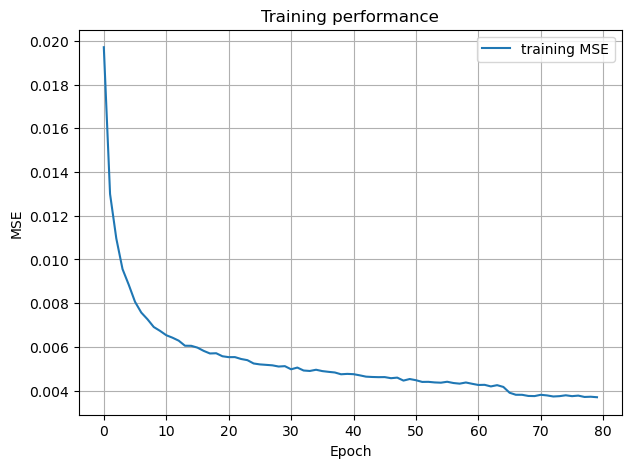

In [31]:
x = training_MES
plt.figure(figsize=(7,5))
plt.title('Training performance')
plt.plot(x, label='training MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
#plt.savefig(os.path.join(os.getcwd(),"training_process")+"\\Increase_Dimension_concatenate_training.jpg")
plt.show()

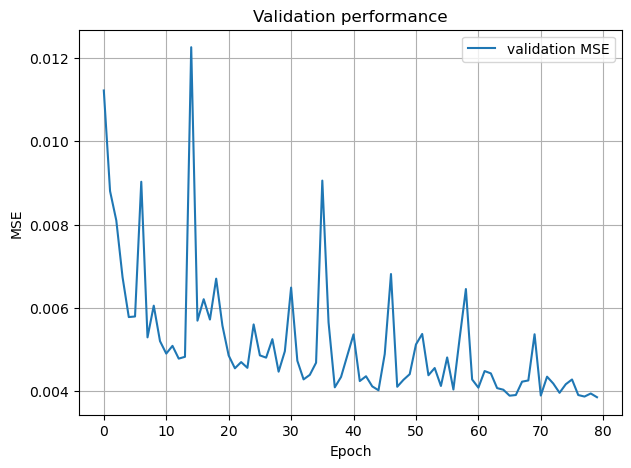

In [32]:
x = vaidation_MSE
plt.figure(figsize=(7,5))
plt.title('Validation performance')
plt.plot(x, label='validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
#plt.savefig(os.path.join(os.getcwd(),"training_process")+"\\Increase_Dimension_concatenate_validation.jpg")
plt.show()

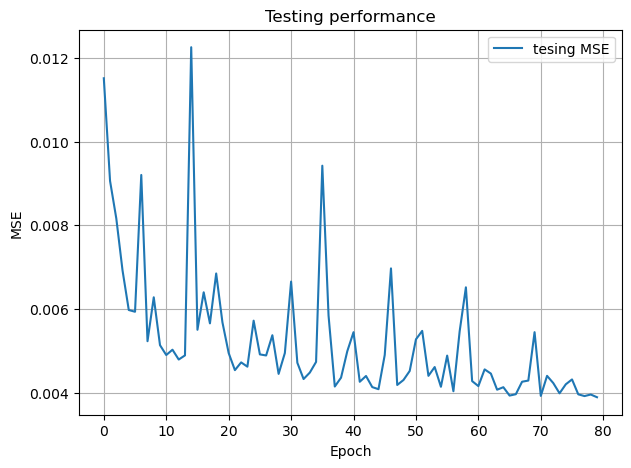

In [33]:
x = testing_MSE
plt.figure(figsize=(7,5))
plt.title('Testing performance')
plt.plot(x, label='tesing MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
#plt.savefig(os.path.join(os.getcwd(),"training_process")+"\\Increase_Dimension_concatenate_testing.jpg")
plt.show()

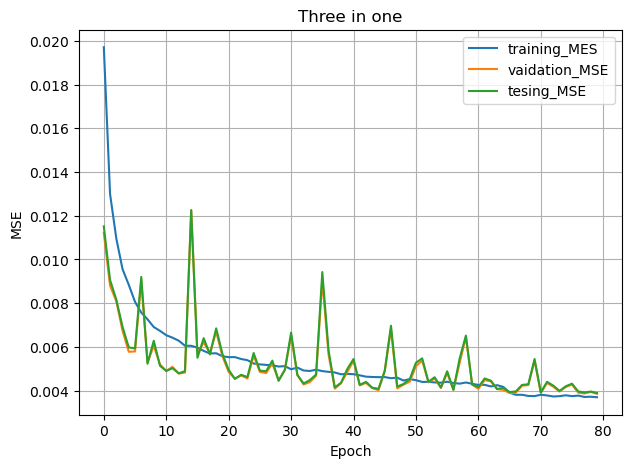

In [34]:
x1 = training_MES
x2 = vaidation_MSE
x3 = testing_MSE
plt.figure(figsize=(7,5))
plt.title('Three in one')
plt.plot(x1, label='training_MES')
plt.plot(x2, label='vaidation_MSE')
plt.plot(x3, label='tesing_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.savefig(os.path.join(os.getcwd(),"training_process")+"\\Increase_Dimension_concatenate_3in1.jpg")
plt.show()

## Save into excel

In [35]:
x1 = np.array(training_MES).reshape(1, -1)
x2 = np.array(vaidation_MSE).reshape(1, -1)
x3 = np.array(testing_MSE).reshape(1, -1)
three = np.vstack((x1,x2,x3))
df = pd.DataFrame(three).T
df.to_csv( os.path.join(os.getcwd(),"training_process") + "\\polynomial_1.csv")

## Model Testing

In [37]:
# model testing
model =  Net_origin_deep()
checkpoint = torch.load('./checkpoint/polynomial_1.pth')
model.load_state_dict(checkpoint['net'])
model.to(device)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
#loss = checkpoint['loss']
test(epoch)

Average testing MSE: = 0.003894427210646992
